# ライブラリ

In [ ]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib
!pip install huggingface_hub==0.19.4 #結果再現のため
!pip install accelerate==0.25.0 #結果再現のため
from datasets import Dataset, ClassLabel, Features, Value
import pandas as pd
import numpy as np
from transformers.trainer_utils import set_seed
from transformers import AutoTokenizer, BatchEncoding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, precision_score
from tqdm import tqdm

# 乱数シードを固定
train_seed = 42
set_seed(train_seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 46.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# データセットの読み込み

In [ ]:
# データセットの読み込み
data = pd.read_csv("/content/drive/MyDrive/研究用_2011140004_吉田/Dataset/統計スキル_数値修正_文章オンリー_UTF_240208.csv")

In [ ]:
# データセットの全体情報確認
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survey_type  314 non-null    object 
 1   StudentID    314 non-null    object 
 2   Duration     314 non-null    int64  
 3   Q1_1         314 non-null    object 
 4   Q1_2         314 non-null    object 
 5   Q1_score     314 non-null    int64  
 6   Q2_1         314 non-null    object 
 7   Q2_2         314 non-null    object 
 8   Q2_score     314 non-null    int64  
 9   Q3_1         314 non-null    object 
 10  Q3_2         314 non-null    object 
 11  Q3_score     314 non-null    int64  
 12  Q4_1         314 non-null    object 
 13  Q4_2         314 non-null    object 
 14  Q4_score     314 non-null    int64  
 15  Q5_1         314 non-null    object 
 16  Q5_2         314 non-null    object 
 17  Q5_score     314 non-null    int64  
 18  Q6_1         314 non-null    object 
 19  Q6_2    

# データセットの分析

In [ ]:
# 回答時間
print("---回答時間(秒)---")
print(f"平均：{data['Duration'].mean()}")
print(f"中央値：{data['Duration'].median()}")
print(f"最大値：{data['Duration'].max()}")
print(f"最小値：{data['Duration'].min()}")
print(f"標準偏差：{data['Duration'].std():.1f}")

---回答時間(秒)---
平均：987.3184713375796
中央値：836.0
最大値：3714
最小値：192
標準偏差：558.5


# データの前処理


In [ ]:
# 設問ごとの選択肢
print("---Q1(喫煙と肺疾患)---")
print(f"・選択肢\n{data['Q1_1'].value_counts()}")
print(f"・選択肢(Bool)\n{data['Q1_1_n'].value_counts()}")
print(f"・得点分布\n{data['Q1_score'].value_counts()}")
print(f"・平均得点\n{data['Q1_score'].mean()}")
print(f"・得点標準偏差\n{data['Q1_score'].std():.1f}")

---Q1(喫煙と肺疾患)---
・選択肢
いいえ    212
はい     102
Name: Q1_1, dtype: int64
・選択肢(Bool)
0    212
1    102
Name: Q1_1_n, dtype: int64
・得点分布
4    111
2     66
1     60
3     39
0     38
Name: Q1_score, dtype: int64
・平均得点
2.3980891719745223
・得点標準偏差
1.4


In [ ]:
print("---Q2(ゲームと暴力)---")
print(data["Q2_1"].value_counts())
print(f"・選択肢(Bool)\n{data['Q2_1_n'].value_counts()}")
print(f"・得点分布\n{data['Q2_score'].value_counts()}")
print(f"・平均得点\n{data['Q2_score'].mean()}")
print(f"・得点標準偏差\n{data['Q2_score'].std():.1f}")

---Q2(ゲームと暴力)---
賛成    197
反対    117
Name: Q2_1, dtype: int64
・選択肢(Bool)
1    197
0    117
Name: Q2_1_n, dtype: int64
・得点分布
1    164
4     39
2     39
3     37
0     35
Name: Q2_score, dtype: int64
・平均得点
1.6210191082802548
・得点標準偏差
1.2


In [ ]:
print("---Q3(交通量と河川汚染)---")
print(data["Q3_1"].value_counts())
print(f"・得点分布\n{data['Q3_score'].value_counts()}")
print(f"・選択肢(Bool)\n{data['Q3_1_n'].value_counts()}")
print(f"・平均得点\n{data['Q3_score'].mean()}")
print(f"・得点標準偏差\n{data['Q3_score'].std():.1f}")

---Q3(交通量と河川汚染)---
賛成    188
反対    126
Name: Q3_1, dtype: int64
・得点分布
1    150
0     51
2     49
3     37
4     27
Name: Q3_score, dtype: int64
・選択肢(Bool)
1    188
0    126
Name: Q3_1_n, dtype: int64
・平均得点
1.4872611464968153
・得点標準偏差
1.2


In [ ]:
print("---Q4(ドイツの人口)---")
print(data["Q4_1"].value_counts())
print(f"・得点分布\n{data['Q4_score'].value_counts()}")
print(f"・選択肢(Bool)\n{data['Q4_1_n'].value_counts()}")
print(f"・平均得点\n{data['Q4_score'].mean()}")
print(f"・得点標準偏差\n{data['Q4_score'].std():.1f}")

---Q4(ドイツの人口)---
反対    179
賛成    135
Name: Q4_1, dtype: int64
・得点分布
1    100
2     95
0     50
3     50
4     19
Name: Q4_score, dtype: int64
・選択肢(Bool)
0    179
1    135
Name: Q4_1_n, dtype: int64
・平均得点
1.643312101910828
・得点標準偏差
1.1


In [ ]:
print("---Q5(パトロールと犯罪)---")
print(data["Q5_1"].value_counts())
print(f"・得点分布\n{data['Q5_score'].value_counts()}")
print(f"・選択肢(Bool)\n{data['Q5_1_n'].value_counts()}")
print(f"・平均得点\n{data['Q5_score'].mean()}")
print(f"・得点標準偏差\n{data['Q5_score'].std():.1f}")

---Q5(パトロールと犯罪)---
反対    182
賛成    132
Name: Q5_1, dtype: int64
・得点分布
2    162
1     73
0     48
3     26
4      5
Name: Q5_score, dtype: int64
・選択肢(Bool)
0    182
1    132
Name: Q5_1_n, dtype: int64
・平均得点
1.5764331210191083
・得点標準偏差
0.9


In [ ]:
print("---Q6(皮膚アレルギーと生活)---")
print(data["Q6_1"].value_counts())
print(f"・得点分布\n{data['Q6_score'].value_counts()}")
print(f"・選択肢(Bool)\n{data['Q6_1_n'].value_counts()}")
print(f"・平均得点\n{data['Q6_score'].mean()}")
print(f"・得点標準偏差\n{data['Q6_score'].std():.1f}")

---Q6(皮膚アレルギーと生活)---
はい     206
いいえ    108
Name: Q6_1, dtype: int64
・得点分布
1    129
0     75
2     59
4     27
3     24
Name: Q6_score, dtype: int64
・選択肢(Bool)
1    206
0    108
Name: Q6_1_n, dtype: int64
・平均得点
1.3598726114649682
・得点標準偏差
1.2


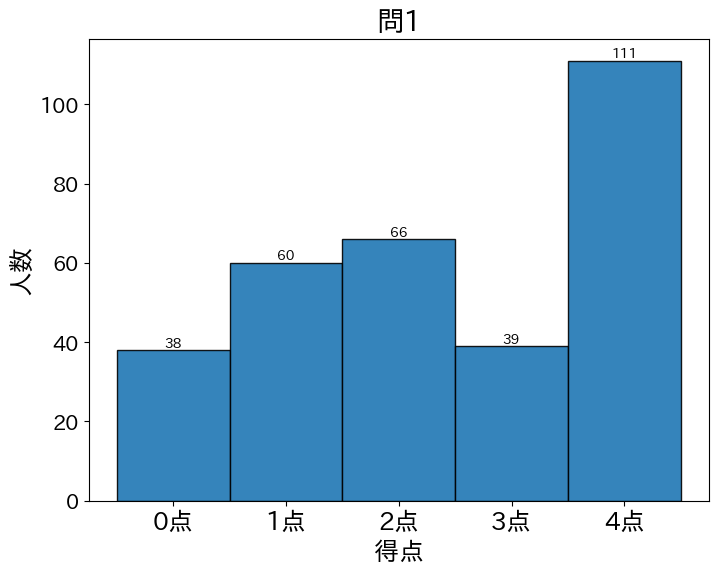

In [ ]:
# 得点ヒストグラム（問1）

import matplotlib.pyplot as plt
import japanize_matplotlib

#bins = [0, 1, 2, 3, 4]
xtri = np.array(["0点", "1点", "2点", "3点", "4点"])
plt.figure(figsize=(8, 6))
counts, edges, patches = plt.hist(data["Q1_score"], bins=range(6), align="left", edgecolor="black", alpha=0.9)
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, patch.get_height(),
             f'{int(count)}', ha='center', va='bottom')
plt.title("問1", fontsize=20)
plt.xlabel("得点", fontsize=18)
plt.ylabel("人数", fontsize=18)
#plt.text(0.5, 105, 'μ=2.40, SD=1.4(n=314)', fontsize=13, color='black', ha='center',
#         fontweight='bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.xticks(range(5), xtri, fontsize=18)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
# 合計スコアを算出して新たなカラムにする
data['total_score'] = data['Q1_score'] + data['Q2_score'] + data['Q3_score'] + data['Q4_score'] + data['Q5_score'] + data['Q6_score']

print("---合計スコア---")
print(f"・得点分布\n{data['total_score'].value_counts()}")
print(f"・平均得点\n{data['total_score'].mean()}")
print(f"・得点標準偏差\n{data['total_score'].std():.1f}")

---合計スコア---
・得点分布
9     34
7     33
13    25
10    25
8     25
11    23
6     22
12    22
14    17
15    14
16    11
17    11
5     10
4     10
3      8
19     5
2      4
1      4
20     4
18     4
0      2
22     1
Name: total_score, dtype: int64
・平均得点
10.085987261146498
・得点標準偏差
4.3


# データの前処理

In [ ]:
# 後でデータ照合するためにindexデータをカラムに保存
data["example_id"] = data.index
pre_data = Dataset.from_pandas(data)

In [ ]:
print(pre_data)

Dataset({
    features: ['Survey_type', 'StudentID', 'Duration', 'Q1_1', 'Q1_2', 'Q1_score', 'Q2_1', 'Q2_2', 'Q2_score', 'Q3_1', 'Q3_2', 'Q3_score', 'Q4_1', 'Q4_2', 'Q4_score', 'Q5_1', 'Q5_2', 'Q5_score', 'Q6_1', 'Q6_2', 'Q6_score', 'Q1_1_n', 'Q2_1_n', 'Q3_1_n', 'Q4_1_n', 'Q5_1_n', 'Q6_1_n', 'CRT_1', 'CRT_2', 'CRT_3', 'CRT_1_knew', 'CRT_2_knew', 'CRT_3_knew', 'Age', 'Gender', 'Education', 'total_score', 'example_id'],
    num_rows: 314
})


In [ ]:
### Hugging Faceのモデルをダウンロード
# サイズが大きいものはcolabo無料版だとエンコード～訓練でエラーがでる可能性あり
# 以下のコードはcl-tohokuのBERT用であるため、他のモデルを使う場合はコードの調整が必要

# Hugging Face Hub上のモデル名を指定
model_name = "cl-tohoku/bert-base-japanese-v3"

# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)
# トークナイザのクラス名を確認
print(type(tokenizer).__name__)
pretrained_model = model_name

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

BertJapaneseTokenizer


# エンコード

In [ ]:
from transformers import BatchEncoding

# questinが文章(入力)、scoringが点数(ラベル)
question = "Q1_2"
scoring = "Q1_core"

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文書分類の事例のテキストをトークナイズし、IDに変換"""
    encoded_example = tokenizer(example["Q1_2"], max_length=256)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = example["Q1_score"]
    return encoded_example

In [ ]:
# 分割のシードを固定し、分割
test_size = 0.3 #テストデータの割合
split_seed = 42

train_test_split = pre_data.train_test_split(test_size=test_size, seed=split_seed)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [ ]:
# 分割したデータセットの確認
print(train_dataset[0])
print(test_dataset[0])

{'Survey_type': 'クラウドワークス', 'StudentID': 'yoshitomoko', 'Duration': 738, 'Q1_1': 'いいえ', 'Q1_2': '人数にそれほどひらきもないので、一概に肺疾患が喫煙と関係しているとは言えない。', 'Q1_score': 2, 'Q2_1': '賛成', 'Q2_2': 'ゲームをする時間が長いと現実とゲームの中がごっちゃになり、関係していると思う。', 'Q2_score': 0, 'Q3_1': '賛成', 'Q3_2': '人が多くなっている証拠だから。', 'Q3_score': 0, 'Q4_1': '反対', 'Q4_2': '高齢化もあるので、一概に子供の数が関係しているとは言えない。', 'Q4_score': 2, 'Q5_1': '反対', 'Q5_2': 'そこまで増大に増えているとはいえない。微増だと思う。', 'Q5_score': 2, 'Q6_1': 'はい', 'Q6_2': 'アレルギーを引き起こしている人の人数が多いから。', 'Q6_score': 0, 'Q1_1_n': 0, 'Q2_1_n': 1, 'Q3_1_n': 1, 'Q4_1_n': 0, 'Q5_1_n': 0, 'Q6_1_n': 1, 'CRT_1': 100.0, 'CRT_2': 100.0, 'CRT_3': 24.0, 'CRT_1_knew': '知らなかった', 'CRT_2_knew': '知らなかった', 'CRT_3_knew': '知らなかった', 'Age': 44, 'Gender': '女', 'Education': '大学(学部)', 'total_score': 6, 'example_id': 276}
{'Survey_type': 'クラウドワークス', 'StudentID': 'ikedey', 'Duration': 506, 'Q1_1': 'いいえ', 'Q1_2': '数に大きな差はなく、根拠に乏しい。', 'Q1_score': 2, 'Q2_1': '反対', 'Q2_2': '根拠が示されていない。', 'Q2_score': 1, 'Q3_1': '反対', 'Q3_2': '関連性と根拠が全く示されていない。', 'Q

In [ ]:
# 訓練データのエンコード
encoded_train_data = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names
)

Parameter 'function'=<function preprocess_text_classification at 0x7e4e79879510> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/219 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# テストデータのエンコード
encoded_test_data = test_dataset.map(
    preprocess_text_classification,
    remove_columns=test_dataset.column_names
)

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

# ミニバッチ構築
本に書いてあったコードを真似ただけでよくわからない

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
batch_inputs = data_collator(encoded_train_data[0:4])
print({name: tensor.size() for name, tensor in batch_inputs.items()})

{'input_ids': torch.Size([4, 54]), 'token_type_ids': torch.Size([4, 54]), 'attention_mask': torch.Size([4, 54]), 'labels': torch.Size([4])}


# モデルの準備

In [ ]:
# ラベル名用のリストを作ってClasslabel型に変換
from datasets import Dataset, ClassLabel, Features, Value
label_names = ["0点", "1点", "2点", "3点", "4点"]
class_label = ClassLabel(num_classes=len(label_names), names=label_names)
features = Features({
    "Sentence": Value('string'),
    "Score": class_label,
})

In [ ]:
# class_labelの確認
print(class_label)

ClassLabel(names=['0点', '1点', '2点', '3点', '4点'], id=None)


In [ ]:
# ラベルの対応設定
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}

In [ ]:
# labelとID(分類名)の対応確認
print(label2id.values())
print(id2label.values())

dict_values([0, 1, 2, 3, 4])
dict_values(['0点', '1点', '2点', '3点', '4点'])


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    # num_labels= ***  ラベルの分類数(自動で行う場合は不要)
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


# モデルの訓練

In [ ]:
## 訓練の設定

train_batch_size=8 #訓練時バッチサイズ
eval_batch_size=8 #評価時バッチサイズ
learning_rate=2e-5 #学習率
epochs=10 #エポック数

training_args = TrainingArguments(
    output_dir="output_wrime",  # 結果の保存フォルダ
    per_device_train_batch_size=train_batch_size,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=eval_batch_size,  # 評価時のバッチサイズ
    learning_rate=learning_rate,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=epochs,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="QWK",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
)

In [ ]:
# QWKの計算定義
def compute_qwk(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"QWK": cohen_kappa_score(labels, predictions, weights='quadratic')}

In [ ]:
### 訓練開始
# *実行すると訓練が開始されます(メモリの使いすぎなどに注意!)

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_data,
    eval_dataset=encoded_test_data,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_qwk,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Qwk
1,1.565500,1.427226,0.302974
2,1.278400,1.124753,0.732763
3,0.918900,0.902532,0.833169
4,0.607000,0.785790,0.874252
5,0.426200,0.751047,0.858019
6,0.230500,0.743831,0.856772
7,0.128900,0.772877,0.836699
8,0.078400,0.822714,0.858684
9,0.053100,0.817973,0.850424
10,0.040500,0.847371,0.863730


TrainOutput(global_step=280, training_loss=0.5327482670545578, metrics={'train_runtime': 51.943, 'train_samples_per_second': 42.162, 'train_steps_per_second': 5.391, 'total_flos': 60481199583180.0, 'train_loss': 0.5327482670545578, 'epoch': 10.0})

# モデルのアップロード
Hugging Faceにアップロードすれば、いつでも作成したモデルをダウンロードできる。

In [ ]:
# モデルをHugging Faceにアップロード(アカウントが必要)
from huggingface_hub import login
login()

In [ ]:
### アップロードする名前を自動で作成(面倒なのと入力ミス対策)

from datetime import datetime
import pytz

# 回答別結果DFのcsv出力用文字列
filename1 = scoring.split("_")[0] + "_split_" + str(split_seed) + "_train_" + str(train_seed)
filename2= pretrained_model.split("/")[1]

# 日本時間のタイムゾーンを設定
jst = pytz.timezone('Asia/Tokyo')

# 現在時刻を日本時間で取得
time = datetime.now(jst).strftime('%Y%m%d_')

model_upload_name = "ATYOSHIDA/" + time + filename1 + "_" + filename2

In [ ]:
# 名前の確認
model_upload_name

'ATYOSHIDA/20231231_Q6_split_40_train_40_bert-base-japanese-v3'

In [ ]:
# Hugging Face Hubのリポジトリ名
repo_name = model_upload_name
# トークナイザとモデルをアップロード
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ATYOSHIDA/20231231_Q6_split_40_train_40_bert-base-japanese-v3/commit/8adda62d55b631b1d4bf81a430e2a5784ba6bd72', commit_message='Upload BertForSequenceClassification', commit_description='', oid='8adda62d55b631b1d4bf81a430e2a5784ba6bd72', pr_url=None, pr_revision=None, pr_num=None)

# エラー分析

In [ ]:
!pip install datasets transformers[ja,torch] matplotlib scikit-learn

In [ ]:
from transformers import pipeline
modeln = "**********"
# 自分がアップしたモデルを選択
sentiment_pipeline = pipeline(model=modeln, device="cuda:0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/936 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# 分析用の設定
デフォルトでは最も確率の高いラベルのみを返すが、すべてのラベルの予測値(確率)を取得してデータフレームに追加する

In [ ]:
# ラベル名の情報を取得するためのClassLabelインスタンス(上の使い回し)

label_names = ["0点", "1点", "2点", "3点", "4点"]
class_label = ClassLabel(num_classes=len(label_names), names=label_names)
features = Features({
    "Q1_2": Value('string'),
    'Q1_score': class_label
})

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(test_dataset)):
    dicts = {}
    probs = {}
    # モデルの予測結果(全ラベル)を取得
    model_prediction = sentiment_pipeline(example["Q1_2"], return_all_scores=True)
    # 正解のラベルIDをラベル名に変換
    true_label = class_label.int2str(example["Q1_score"])

    dicts.update({"example_id": example["example_id"]})

    #probsに各ラベルごとの予測値を格納
    for j in model_prediction[0]:
      label_n = j.get("label")
      label_p = j.get("score")
      probs.update({label_n: label_p})

    #予測ラベル(最高確率)を取得
    pred_label = max(probs, key=probs.get)
    dicts.update(probs)
    dicts.update({"pred_label": pred_label,
                  "true_label": true_label})

    results.append(dicts)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
1it [00:00,  1.11it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
95it [00:01, 50.84it/s]


In [ ]:
results_df = pd.DataFrame(results)
results_df

,example_id,0点,1点,2点,3点,4点,pred_label,true_label
0,68,0.027564,0.025577,0.793560,0.109260,0.044039,2点,2点
1,134,0.002865,0.001834,0.003073,0.008228,0.983999,4点,4点
2,290,0.004465,0.004110,0.003612,0.006479,0.981333,4点,4点
3,201,0.568091,0.043866,0.308638,0.054627,0.024778,0点,0点
4,38,0.022655,0.958433,0.010553,0.004593,0.003766,1点,1点
...,...,...,...,...,...,...,...,...
90,53,0.019153,0.016652,0.038290,0.612292,0.313612,3点,3点
91,209,0.154911,0.104888,0.688771,0.038252,0.013178,2点,0点
92,138,0.010489,0.029315,0.938991,0.018021,0.003183,2点,2点
93,294,0.118911,0.738205,0.018317,0.092897,0.031670,1点,1点


# 混同行列など

In [ ]:
!pip install colorspacious

In [ ]:
from matplotlib import colormaps
list(colormaps)
from colorspacious import cspace_converter
import matplotlib as mpl

cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

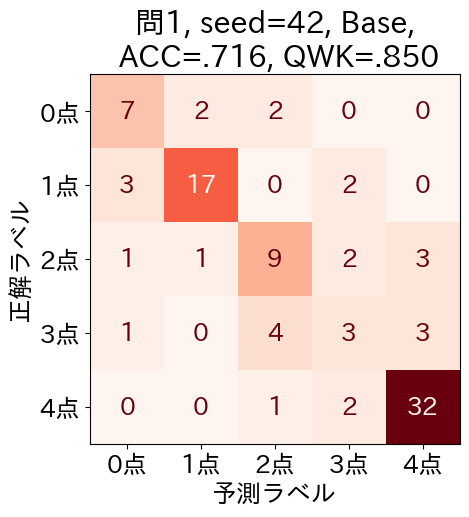

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plt.rcParams["font.size"] = 18  # 文字サイズを大きくする
# 混同行列の作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# 混同行列を画像として表示
disp=ConfusionMatrixDisplay(confusion_matrix, display_labels=class_label.names).plot(cmap="Reds",colorbar=False)
plt.title("問1, seed=42, Base,\n ACC=.716, QWK=.850")
plt.xlabel("予測ラベル")
plt.ylabel("正解ラベル")
plt.show()

In [ ]:
# ラベル名を数値に変換する関数の定義
def assign_label(sentiment):
    if sentiment == '0点':
        return 0
    elif sentiment == '1点':
        return 1
    elif sentiment == '2点':
        return 2
    elif sentiment == '3点':
        return 3
    elif sentiment == '4点':
        return 4

In [ ]:
# 結果データフレームに数値ラベルとその差を追加
results_df["pred_label"] = results_df["pred_label"].apply(assign_label)
results_df["true_label"] = results_df["true_label"].apply(assign_label)

In [ ]:
results_df["diff"] = results_df["pred_label"] - results_df["true_label"]
results_df

,example_id,0点,1点,2点,3点,4点,pred_label,true_label,diff
0,68,0.027564,0.025577,0.793560,0.109260,0.044039,2,2,0
1,134,0.002865,0.001834,0.003073,0.008228,0.983999,4,4,0
2,290,0.004465,0.004110,0.003612,0.006479,0.981333,4,4,0
3,201,0.568091,0.043866,0.308638,0.054627,0.024778,0,0,0
4,38,0.022655,0.958433,0.010553,0.004593,0.003766,1,1,0
...,...,...,...,...,...,...,...,...,...
90,53,0.019153,0.016652,0.038290,0.612292,0.313612,3,3,0
91,209,0.154911,0.104888,0.688771,0.038252,0.013178,2,0,2
92,138,0.010489,0.029315,0.938991,0.018021,0.003183,2,2,0
93,294,0.118911,0.738205,0.018317,0.092897,0.031670,1,1,0


In [ ]:
# モデルの各評価指標
print("-----Metrics-----")
acc = accuracy_score(y_true=results_df['true_label'], y_pred=results_df['pred_label']).round(decimals=3)
pre = precision_score(y_true=results_df['true_label'], y_pred=results_df['pred_label'], average='macro').round(decimals=3)
qwk = cohen_kappa_score(y1=results_df['true_label'], y2=results_df['pred_label'], weights='quadratic').round(decimals=3)

print(f"Accuracy: {acc}")
print(f"QWK: {qwk}")

-----Metrics-----
Accuracy: 0.716
Precision(macro): 0.634
QWK: 0.85


In [ ]:
# 以下、モデルごとの設定と結果を自動でcsvに出力するためのコード

# 分割方法
splitting = "Train/Test"
gpu = "T4(High Memory)"

# 評価指標のcsv出力
evaluated = pd.DataFrame(
    {"Question": [scoring.split("_")[0]],
     "Upload_Name": [repo_name.split("/")[1]],
     "Pre_Trained_Name": [pretrained_model],
     "GPU": [gpu],
     "Splitting": [splitting],
     "Test %": [test_size],
     "Split_Seed": [split_seed],
     "Train_Seed": [train_seed],
     "Train_Batch": [train_batch_size],
     "Eval_Batch": [eval_batch_size],
     "Learning_Rate": [learning_rate],
     "Epoch": [epochs],
     "Accuracy": [acc],
     "QWK": [qwk]}
    )
evaluated

,Question,Upload_Name,Pre_Trained_Name,GPU,Splitting,Test %,Split_Seed,Train_Seed,Train_Batch,Eval_Batch,Learning_Rate,Epoch,Accuracy,QWK
0,Q6,20231231_Q6_split_40_train_40_bert-base-japane...,cl-tohoku/bert-base-japanese-v3,T4(High Memory),Train/Test,0.3,40,40,8,8,0.00002,10,0.747,0.838


In [ ]:
# 評価の結果をcsvに追加して出力
evaluated.to_csv("**********",
                 mode='a', header=False, index=False)

In [ ]:
from datetime import datetime
import pytz

# 回答別結果DFのcsv出力用文字列
filename1 = scoring.split("_")[0] + "_split_" + str(split_seed) + "_train_" + str(train_seed)
filename2= pretrained_model.split("/")[1]
filename3 = "qwk0" + str(int(qwk*100))

# 日本時間のタイムゾーンを設定
jst = pytz.timezone('Asia/Tokyo')

# 現在時刻を日本時間で取得
current_time = datetime.now(jst).strftime('%Y%m%d_%H%M')

# ファイルの名前を自動で決定
filename = filename1 + "_" + filename2 + "_" + filename3 + "_" + current_time


In [ ]:
filename

'Q6_split_40_train_40_bert-base-japanese-v3_qwk083_20231231_1141'

In [ ]:
# 名前を自動で決定しcsvで個別出力
results_df.to_csv("**********")